In [1]:
import numpy as np
from scipy.stats import expon
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_datasets as tfds

In [2]:
LEARNING_RATE = 0.01
MOMENTUM = 0.9
BATCH_SIZE = 32
NUM_EPOCHS = 50

In [3]:
class LogisticRegression(tf.keras.Model):
    def __init__(self, n_classes, l2_lambda=0.0):
        super().__init__()
        self.dense = tf.keras.layers.Dense(
            n_classes,
            kernel_initializer=tf.keras.initializers.RandomNormal(),
            kernel_regularizer=tf.keras.regularizers.l2(l2_lambda)
        )

    def call(self, inputs, training=None):
        x = self.dense(inputs)
        x = tf.nn.softmax(x)
        return x

In [4]:
def preprocess(example):
    return tf.reshape(example['image']/255, [-1]), example['label']

train = tfds.load('mnist', split='train').map(preprocess).shuffle(1024).batch(BATCH_SIZE)
test = tfds.load('mnist', split='test').map(preprocess).batch(BATCH_SIZE)

In [5]:
def get_train_step():
    @tf.function
    def train_step(model, inputs, labels, criterion, optimizer, metrics, importance_weights=None):
        with tf.GradientTape() as tape:
            outputs = model(inputs, training=True)
            loss = criterion(labels, outputs) + tf.reduce_sum(model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        metrics['train_loss'].update_state(loss)
        metrics['train_accuracy'].update_state(labels, outputs)
    return train_step

def get_test_step():
    @tf.function
    def test_step(model, inputs, labels, criterion, metrics):
        outputs = model(inputs, training=False)
        loss = criterion(labels, outputs) + tf.reduce_sum(model.losses)
        metrics['test_loss'].update_state(loss)
        metrics['test_accuracy'].update_state(labels, outputs)
    return test_step

metrics = {
    'train_loss': tf.keras.metrics.Mean(name='train_loss'),
    'train_accuracy': tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy'),
    'test_loss': tf.keras.metrics.Mean(name='test_loss'),
    'test_accuracy': tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy'),
}

# Baseline MNIST with underfitting Logistic Regression

Epoch 0: Train Loss=0.4172658622264862, Train Accuracy=0.8848666548728943,
         Test Loss=0.3127751350402832, Test Accuracy=0.9117000102996826
Epoch 1: Train Loss=0.3136827051639557, Train Accuracy=0.9112333059310913,
         Test Loss=0.2915504276752472, Test Accuracy=0.91839998960495
Epoch 2: Train Loss=0.29681137204170227, Train Accuracy=0.9163500070571899,
         Test Loss=0.2830300033092499, Test Accuracy=0.9199000000953674
Epoch 3: Train Loss=0.2880821228027344, Train Accuracy=0.9193000197410583,
         Test Loss=0.27815988659858704, Test Accuracy=0.9221000075340271
Epoch 4: Train Loss=0.2820948362350464, Train Accuracy=0.9207000136375427,
         Test Loss=0.2774377763271332, Test Accuracy=0.9200999736785889
Epoch 5: Train Loss=0.2777237892150879, Train Accuracy=0.9223666787147522,
         Test Loss=0.27708810567855835, Test Accuracy=0.9207000136375427
Epoch 6: Train Loss=0.27412813901901245, Train Accuracy=0.9233166575431824,
         Test Loss=0.2770450711250305, Te

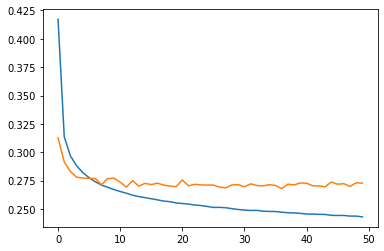

In [6]:
model = LogisticRegression(10)
criterion = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(LEARNING_RATE, MOMENTUM)

train_step = get_train_step()
test_step = get_test_step()

train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(NUM_EPOCHS):
    
    for metric in metrics:
        metrics[metric].reset_states()
    
    for inputs, labels in train:
        train_step(model, inputs, labels, criterion, optimizer, metrics)
        
    for inputs, labels in test:
        test_step(model, inputs, labels, criterion, metrics)
    
    train_loss.append(metrics['train_loss'].result())
    train_accuracy.append(metrics['train_accuracy'].result())
    test_loss.append(metrics['test_loss'].result())
    test_accuracy.append(metrics['test_accuracy'].result())
    
    print(
        f'Epoch {epoch}: Train Loss={train_loss[-1]}, Train Accuracy={train_accuracy[-1]},\n \
        Test Loss={test_loss[-1]}, Test Accuracy={test_accuracy[-1]}'
    )
    
plt.plot(train_loss)
plt.plot(test_loss)

In [7]:
def resample_dataset(dataset, density, training=False):
    all_inputs = []
    all_labels = []
    resampled_inputs = []
    resampled_labels = []
    
    for inputs, labels in dataset:
        all_inputs.append(inputs)
        all_labels.append(labels)
        
    all_inputs = np.vstack(all_inputs)
    all_labels = np.hstack(all_labels)
    
    for digit, p_digit in enumerate(density):
        print(f'{digit}: {p_digit}')
        index = np.where(all_labels == digit)[0]
        index = index[:int(len(index)*p_digit)]
        resampled_inputs.append(all_inputs[index])
        resampled_labels.append(all_labels[index])
        
    dataset = tf.data.Dataset.from_tensor_slices(
        (np.vstack(resampled_inputs), np.hstack(resampled_labels))
    )

    if training:
        return dataset.shuffle(1024).batch(BATCH_SIZE)
    else:
        return dataset.batch(BATCH_SIZE)

density, _ = np.histogram(expon.rvs(scale=1/0.5, size=1000), bins=range(11), density=True)
train_density = np.random.permutation(density)
test_density = np.random.permutation(density)

# Exponentially resampled MNIST with stationary train/test

0: 0.4118831822759315
1: 0.021148036253776436
2: 0.038267875125881166
3: 0.08559919436052367
4: 0.1309164149043303
5: 0.24471299093655588
6: 0.011077542799597181
7: 0.0030211480362537764
8: 0.008056394763343404
9: 0.045317220543806644
0: 0.4118831822759315
1: 0.021148036253776436
2: 0.038267875125881166
3: 0.08559919436052367
4: 0.1309164149043303
5: 0.24471299093655588
6: 0.011077542799597181
7: 0.0030211480362537764
8: 0.008056394763343404
9: 0.045317220543806644
Epoch 0: Train Loss=0.7973451614379883, Train Accuracy=0.8141531944274902,
         Test Loss=0.6163304448127747, Test Accuracy=0.8068535923957825
Epoch 1: Train Loss=0.339172899723053, Train Accuracy=0.8998625874519348,
         Test Loss=0.5108764171600342, Test Accuracy=0.8369678258895874
Epoch 2: Train Loss=0.28856945037841797, Train Accuracy=0.9130882620811462,
         Test Loss=0.36720579862594604, Test Accuracy=0.8982346653938293
Epoch 3: Train Loss=0.24714507162570953, Train Accuracy=0.9240810871124268,
         Tes

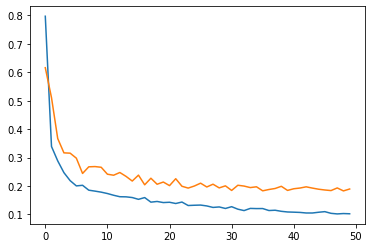

In [8]:
model = LogisticRegression(10)
criterion = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(LEARNING_RATE, MOMENTUM)

train_step = get_train_step()
test_step = get_test_step()

resampled_train = resample_dataset(train, train_density, training=True)
resampled_test = resample_dataset(test, train_density, training=False)

train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(NUM_EPOCHS):
    
    for metric in metrics:
        metrics[metric].reset_states()
    
    for inputs, labels in resampled_train:
        train_step(model, inputs, labels, criterion, optimizer, metrics)
        
    for inputs, labels in resampled_test:
        test_step(model, inputs, labels, criterion, metrics)
    
    train_loss.append(metrics['train_loss'].result())
    train_accuracy.append(metrics['train_accuracy'].result())
    test_loss.append(metrics['test_loss'].result())
    test_accuracy.append(metrics['test_accuracy'].result())
    
    print(
        f'Epoch {epoch}: Train Loss={train_loss[-1]}, Train Accuracy={train_accuracy[-1]},\n \
        Test Loss={test_loss[-1]}, Test Accuracy={test_accuracy[-1]}'
    )
    
plt.plot(train_loss)
plt.plot(test_loss)

# Exponentially resampled MNIST with shifted train/test

0: 0.4118831822759315
1: 0.021148036253776436
2: 0.038267875125881166
3: 0.08559919436052367
4: 0.1309164149043303
5: 0.24471299093655588
6: 0.011077542799597181
7: 0.0030211480362537764
8: 0.008056394763343404
9: 0.045317220543806644
0: 0.24471299093655588
1: 0.0030211480362537764
2: 0.011077542799597181
3: 0.045317220543806644
4: 0.4118831822759315
5: 0.021148036253776436
6: 0.038267875125881166
7: 0.008056394763343404
8: 0.1309164149043303
9: 0.08559919436052367
Epoch 0: Train Loss=0.7422053813934326, Train Accuracy=0.8223978281021118,
         Test Loss=0.6633153557777405, Test Accuracy=0.7778915166854858
Epoch 1: Train Loss=0.3018774390220642, Train Accuracy=0.912572979927063,
         Test Loss=0.6290462613105774, Test Accuracy=0.7891504764556885
Epoch 2: Train Loss=0.2566663920879364, Train Accuracy=0.9189282059669495,
         Test Loss=0.5499464273452759, Test Accuracy=0.8167860507965088
Epoch 3: Train Loss=0.22967270016670227, Train Accuracy=0.9306080341339111,
         Test 

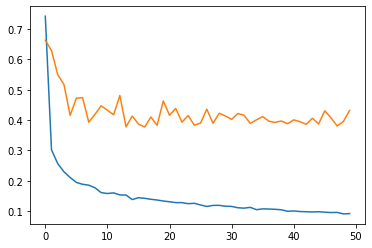

In [9]:
model = LogisticRegression(10)
criterion = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(LEARNING_RATE, MOMENTUM)

train_step = get_train_step()
test_step = get_test_step()

resampled_train = resample_dataset(train, train_density, training=True)
resampled_test = resample_dataset(test, test_density, training=False)

train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

for epoch in range(NUM_EPOCHS):
    
    for metric in metrics:
        metrics[metric].reset_states()
    
    for inputs, labels in resampled_train:
        train_step(model, inputs, labels, criterion, optimizer, metrics)
        
    for inputs, labels in resampled_test:
        test_step(model, inputs, labels, criterion, metrics)
    
    train_loss.append(metrics['train_loss'].result())
    train_accuracy.append(metrics['train_accuracy'].result())
    test_loss.append(metrics['test_loss'].result())
    test_accuracy.append(metrics['test_accuracy'].result())
    
    print(
        f'Epoch {epoch}: Train Loss={train_loss[-1]}, Train Accuracy={train_accuracy[-1]},\n \
        Test Loss={test_loss[-1]}, Test Accuracy={test_accuracy[-1]}'
    )
    
plt.plot(train_loss)
plt.plot(test_loss)

# Importance weights

In [10]:
def get_train_step():
    @tf.function
    def train_step(model, inputs, labels, criterion, optimizer, metrics, importance_weights):
        with tf.GradientTape() as tape:
            outputs = model(inputs, training=True)
            per_example_loss = criterion(labels, outputs)
            per_example_weight = tf.gather(importance_weights, labels)
            loss = tf.tensordot(per_example_loss, per_example_weight, 1) + tf.reduce_sum(model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        metrics['train_loss'].update_state(loss)
        metrics['train_accuracy'].update_state(labels, outputs)
    return train_step

def get_test_step():
    @tf.function
    def test_step(model, inputs, labels, criterion, metrics):
        outputs = model(inputs, training=False)
        per_example_loss = criterion(labels, outputs)
        loss = tf.reduce_mean(per_example_loss) + tf.reduce_sum(model.losses)
        metrics['test_loss'].update_state(loss)
        metrics['test_accuracy'].update_state(labels, outputs)
    return test_step

### Oracle

0: 0.4118831822759315
1: 0.021148036253776436
2: 0.038267875125881166
3: 0.08559919436052367
4: 0.1309164149043303
5: 0.24471299093655588
6: 0.011077542799597181
7: 0.0030211480362537764
8: 0.008056394763343404
9: 0.045317220543806644
0: 0.24471299093655588
1: 0.0030211480362537764
2: 0.011077542799597181
3: 0.045317220543806644
4: 0.4118831822759315
5: 0.021148036253776436
6: 0.038267875125881166
7: 0.008056394763343404
8: 0.1309164149043303
9: 0.08559919436052367
Epoch 0: Train Loss=0.8051008582115173, Train Accuracy=0.6401579976081848,
         Test Loss=0.6934313774108887, Test Accuracy=0.772773802280426
Epoch 1: Train Loss=0.37086042761802673, Train Accuracy=0.7473376989364624,
         Test Loss=0.45763927698135376, Test Accuracy=0.8515864610671997
Epoch 2: Train Loss=0.32714414596557617, Train Accuracy=0.7748196721076965,
         Test Loss=0.35846468806266785, Test Accuracy=0.8894575238227844
Epoch 3: Train Loss=0.27407553791999817, Train Accuracy=0.7864995002746582,
         T

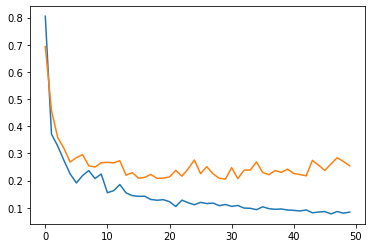

In [11]:
model = LogisticRegression(10)
criterion = tf.keras.losses.SparseCategoricalCrossentropy(reduction=tf.keras.losses.Reduction.NONE)
optimizer = tf.keras.optimizers.SGD(LEARNING_RATE, MOMENTUM)

train_step = get_train_step()
test_step = get_test_step()

resampled_train = resample_dataset(train, train_density, training=True)
resampled_test = resample_dataset(test, test_density, training=False)

train_loss = []
train_accuracy = []
test_loss = []
test_accuracy = []

importance_weights = test_density / train_density
importance_weights = importance_weights / np.sum(importance_weights)
importance_weights = importance_weights.astype(np.float32)

for epoch in range(NUM_EPOCHS):
    
    for metric in metrics:
        metrics[metric].reset_states()
    
    for inputs, labels in resampled_train:
        train_step(model, inputs, labels, criterion, optimizer, metrics, importance_weights)
        
    for inputs, labels in resampled_test:
        test_step(model, inputs, labels, criterion, metrics)
    
    train_loss.append(metrics['train_loss'].result())
    train_accuracy.append(metrics['train_accuracy'].result())
    test_loss.append(metrics['test_loss'].result())
    test_accuracy.append(metrics['test_accuracy'].result())
    
    print(
        f'Epoch {epoch}: Train Loss={train_loss[-1]}, Train Accuracy={train_accuracy[-1]},\n \
        Test Loss={test_loss[-1]}, Test Accuracy={test_accuracy[-1]}'
    )
    
plt.plot(train_loss)
plt.plot(test_loss)

In [12]:
def confusion_matrix(model, dataset):
    all_labels = []
    all_predictions = []

    for inputs, labels in dataset:
        outputs = model(inputs, training=False)
        all_labels.append(labels)
        all_predictions.append(tf.argmax(outputs, axis=1))
    
    return tf.math.confusion_matrix(
        np.hstack(all_labels), np.hstack(all_predictions)
    )